# Library

In [25]:
from beb_chargers.scripts.script_helpers import build_trips_df, \
    build_charger_location_inputs
from beb_chargers.opt.charger_location import ChargerLocationModel
from beb_chargers.gtfs_beb import GTFSData
from beb_chargers.vis import plot_trips_and_terminals, plot_deadhead
from pathlib import Path
import datetime
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)

# Parameters

In [26]:
# Power output of each charger. Note that the model expects a unit of
# kilowatt-hours per minute, so that the amount of energy gained equals
# charging time (in minutes) multiplied by power (in kWh/min). Here, we
# use 450 kW = 450 / 60 kWh/min
chg_pwrs = 450 / 60

# Maximum number of chargers per site. We'll set it to 4 everywhere
n_max = 4

# Cost parameters. See TRC paper for where the values come from.
s_cost = 200000
c_cost = 698447
alpha = 190 * 365 * 12 / 60

# Locate CSV file giving candidate charger sites for this instance
site_fname = Path.cwd().parent / 'beb_chargers' / 'data' / 'chargers_nyc.csv'

# Load candidate charging sites given by Metro and add params as columns
loc_df = pd.read_csv(site_fname)
loc_df['max_chargers'] = n_max
loc_df['kw'] = chg_pwrs * 60
loc_df['fixed_cost'] = s_cost
loc_df['charger_cost'] = c_cost

# Define coordinates of overnight depot at South Base
depot_coords = (40.819197, -73.957060)

# Data

In [27]:
# Directory to GTFS files, as a platform-agnostic path
gtfs_dir = Path.cwd().parent / 'beb_chargers' / 'data' / 'gtfs' / 'GTFS'

# Load GTFS data into our custom object
gtfs = GTFSData.from_dir(gtfs_dir)

In [28]:
# Battery capacity in kWh
battery_cap = 550
# Energy consumption per mile for all buses (we'll assume it's the same
# for all buses here)
kwh_per_mi = 3

In [29]:
list(gtfs.routes_df[gtfs.routes_df['route_short_name'].str.startswith('M', na=False)]['route_short_name'].values)

['MVAS',
 'MQAS',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M7',
 'M8',
 'M9',
 'M10',
 'M100',
 'M101',
 'M102',
 'M103',
 'M104',
 'M106',
 'M11',
 'M116',
 'M12',
 'M125',
 'M141A',
 'M14A-SBS',
 'M14D-SBS',
 'M15',
 'M15-SBS',
 'M20',
 'M21',
 'M22',
 'M23-SBS',
 'M31',
 'M34-SBS',
 'M34A-SBS',
 'M35',
 'M42',
 'M50',
 'M55',
 'M57',
 'M60-SBS',
 'M66',
 'M72',
 'M79-SBS',
 'M86-SBS',
 'M96',
 'M98',
 'M99',
 'M90',
 'MW-ML',
 'M191']

In [30]:
import csv
import random

In [31]:
import csv
import random

def read_routes_file(filename):
    """
    Reads the routes file and returns a list of route IDs that start with 'M'.
    
    Args:
        filename (str): Path to the CSV file containing route IDs.
    
    Returns:
        list: Filtered list of route IDs where the first letter is 'M'.
    """
    route_ids = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['route_id'].startswith('M'):  # Filter routes that start with 'M'
                route_ids.append(row['route_id'])
    return route_ids

def random_select_routes(route_ids, percentage=1):
    """
    Randomly selects a subset of routes from the filtered list.
    
    Args:
        route_ids (list): List of filtered route IDs.
        percentage (float): Percentage of routes to select per iteration.
    
    Returns:
        list: Randomly selected route IDs.
    """
    num_to_select = round(len(route_ids) * percentage)
    return random.sample(route_ids, num_to_select) if route_ids else []

def main():
    filename = Path.cwd().parent / 'beb_chargers' / 'data' / 'gtfs' / 'GTFS' / 'routes.txt'
    num_iterations = 10  # Define the number of iterations
    
    route_ids = read_routes_file(filename)  # Read and filter routes
    print(f"Total number of routes starting with 'M': {len(route_ids)}")
    
    all_results = []
    
    for i in range(num_iterations):
        selected = random_select_routes(route_ids)  # Select 20% of the filtered routes
        all_results.append(selected)
        print(f"\nIteration {i+1}:")
        print(f"Selected {len(selected)} routes: {selected}")
    
    return all_results

if __name__ == "__main__":
    random.seed(42)  # Ensure reproducibility
    
    # Run the main process
    results = main()
    
    print("\nFinal 2D array of selected route_ids:")
    for i, row in enumerate(results):
        print(f"Row {i+1}: {row}")

Total number of routes starting with 'M': 48

Iteration 1:
Selected 48 routes: ['M72', 'M7', 'MQAS', 'M11', 'M104', 'M103', 'M8', 'M5', 'M42', 'M4', 'M57', 'M21', 'M1', 'M99', 'M60+', 'M102', 'M86+', 'M106', 'M12', 'MVAS', 'M98', 'M191', 'M14A+', 'M125', 'M15+', 'M55', 'M34A+', 'M90', 'M34+', 'M116', 'M79+', 'M22', 'M35', 'M100', 'M20', 'M96', 'M3', 'M50', 'M2', 'M101', 'M66', 'M31', 'M9', 'M141A', 'M10', 'M15', 'M14D+', 'M23+']

Iteration 2:
Selected 48 routes: ['M90', 'M23+', 'M42', 'M7', 'M15', 'M4', 'M50', 'M116', 'M66', 'M14D+', 'M55', 'M101', 'M3', 'M1', 'M103', 'M72', 'M86+', 'M21', 'M98', 'M31', 'M2', 'M57', 'M8', 'M35', 'M125', 'M100', 'M34+', 'M14A+', 'M60+', 'M5', 'M15+', 'M99', 'M141A', 'M11', 'M12', 'M22', 'M106', 'M191', 'M34A+', 'M79+', 'M20', 'M104', 'M102', 'MVAS', 'MQAS', 'M96', 'M10', 'M9']

Iteration 3:
Selected 48 routes: ['M11', 'M3', 'M102', 'M55', 'M125', 'M99', 'M79+', 'M34+', 'M15+', 'M23+', 'M9', 'M106', 'M8', 'M104', 'M98', 'M21', 'M66', 'M100', 'M7', 'M90',

In [32]:
results = main()

Total number of routes starting with 'M': 48

Iteration 1:
Selected 48 routes: ['M90', 'M12', 'M34A+', 'M191', 'M86+', 'M20', 'M125', 'M15+', 'M116', 'M50', 'M8', 'M101', 'M96', 'M15', 'M100', 'M98', 'M72', 'M11', 'M60+', 'MVAS', 'M9', 'M21', 'M5', 'M102', 'M66', 'M99', 'M79+', 'M10', 'M103', 'M14A+', 'M14D+', 'M34+', 'M104', 'M55', 'M31', 'M35', 'M1', 'M141A', 'MQAS', 'M3', 'M4', 'M22', 'M23+', 'M42', 'M7', 'M106', 'M57', 'M2']

Iteration 2:
Selected 48 routes: ['M1', 'M104', 'M31', 'M66', 'M3', 'M23+', 'M20', 'M72', 'M55', 'M101', 'M15', 'M34+', 'M15+', 'M90', 'M9', 'MVAS', 'M5', 'M57', 'M102', 'M7', 'M4', 'M50', 'M14A+', 'M106', 'M103', 'MQAS', 'M11', 'M22', 'M2', 'M14D+', 'M96', 'M116', 'M10', 'M60+', 'M125', 'M35', 'M100', 'M8', 'M98', 'M42', 'M86+', 'M79+', 'M21', 'M12', 'M141A', 'M99', 'M34A+', 'M191']

Iteration 3:
Selected 48 routes: ['M35', 'M34+', 'M72', 'M104', 'M11', 'M22', 'M3', 'M116', 'M98', 'M96', 'M141A', 'M125', 'M42', 'M4', 'M8', 'M9', 'M103', 'M101', 'M14A+', 'M79+

In [33]:
# All routes included in analysis
beb_routes = [
    'X27', 'X37', 'Q58', 'X28', 'X38', 'B6', 'SIM4', 'SIM10', 'B82-SBS', 'SIM3', 'SIM8', 'Q27', 'SIM33', 'B35', 'SIM6', 'Bx1', 'Bx2', 'SIM34',
    'M14A-SBS', 'M14D-SBS', 'M15-SBS', 'M23-SBS', 'M34-SBS', 'M34A-SBS', 'M60-SBS', 'M79-SBS', 'M86-SBS'
    'B44-SBS', 'B46-SBS', 'Bx6-SBS', 'Bx12-SBS', 'Bx41-SBS',
    'Q44-SBS', 'S79-SBS'
]
beb_routes = [str(r) for r in beb_routes] + list(gtfs.routes_df[gtfs.routes_df['route_short_name'].str.startswith('M', na=False)]['route_short_name'].values)

# beb_routes = results[0]


import csv
import random

def read_routes_file(filename):
    """
    Read routes file and return route_ids list
    Args:
        filename: CSV path
    Returns:
        route_ids list
    """
    route_ids = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            route_ids.append(row['route_id'])
    return route_ids

def filter_m_routes(route_ids):
    """
    Filter routes that start with 'M'
    Args:
        route_ids: list of all route IDs
    Returns:
        list of route IDs starting with 'M'
    """
    return [route for route in route_ids if route.startswith('M')]

def random_select_routes_with_m_first(route_ids, percentage=0.1):
    """
    Select routes with first one being M-route
    Args:
        route_ids: all routes ID
        percentage: percentage to select
    Returns:
        selected routes ID list starting with an M-route
    """
    # Separate M routes and non-M routes
    m_routes = filter_m_routes(route_ids)
    non_m_routes = [r for r in route_ids if not r.startswith('M')]
    
    if not m_routes:
        raise ValueError("No M-routes found in the input data")
    
    # Calculate how many additional routes to select after M-route
    total_to_select = round(len(route_ids) * percentage)
    remaining_to_select = total_to_select - 1  # -1 because we'll select one M-route
    
    # Select one M-route for the first position
    selected_routes = [random.choice(m_routes)]
    
    # Select remaining routes from all available routes (excluding the selected M-route)
    available_routes = [r for r in route_ids if r != selected_routes[0]]
    
    # Randomly select the remaining routes
    for _ in range(remaining_to_select):
        if not available_routes:
            break
        idx = random.randrange(len(available_routes))
        selected_routes.append(available_routes.pop(idx))
    
    return selected_routes

def main():
    filename = Path.cwd().parent / 'beb_chargers' / 'data' / 'gtfs' / 'GTFS' / 'routes.txt'
    num_iterations = 10
    
    route_ids = read_routes_file(filename)
    print(f"Total number of routes: {len(route_ids)}")
    print(f"Number of M-routes: {len(filter_m_routes(route_ids))}")
    
    all_results = []
    
    for i in range(num_iterations):
        selected = random_select_routes_with_m_first(route_ids)
        all_results.append(selected)
        print(f"\nIteration {i+1}:")
        print(f"Selected {len(selected)} routes: {selected}")
        print(f"First route starts with 'M': {selected[0].startswith('M')}")
    
    return all_results

if __name__ == "__main__":
    random.seed(42)
    
    # Run main program
    results = main()
    
    print("\nFinal 2D array of selected route_ids:")
    for i, row in enumerate(results):
        print(f"Row {i+1}: {row}")

In [34]:
# We'll run analysis for March 28, 2024
ocl_date = datetime.datetime(2025, 3, 14)
# Call helper function to build up DF
beb_trips = build_trips_df(
    gtfs=gtfs,
    date=ocl_date,
    routes=beb_routes,
    depot_coords=depot_coords,
    add_depot_dh=True,
    add_kwh_per_mi=False,
    add_durations=False,
    routes_60=[]
)
# Add a column giving energy consumption for each trip
beb_trips['kwh_per_mi'] = kwh_per_mi

INFO:gtfs_data:12792 unique route requests. 4 ORS calls required.
INFO:gtfs_data:API request 1 underway.
INFO:gtfs_data:OSM request: 28 origins, 123 destinations (3444 total routes)
INFO:gtfs_data:API request 2 underway.
INFO:gtfs_data:OSM request: 28 origins, 123 destinations (3444 total routes)
INFO:gtfs_data:API request 3 underway.
INFO:gtfs_data:OSM request: 28 origins, 123 destinations (3444 total routes)
INFO:gtfs_data:API request 4 underway.
INFO:gtfs_data:OSM request: 20 origins, 123 destinations (2460 total routes)
INFO:gtfs_data:OpenRouteService matrix returned in 4.75 seconds.


In [35]:
beb_trips

,trip_id,route_id,service_id,block_id,shape_id,route,route_type,route_desc,start_time,end_time,trip_idx,start_lat,start_lon,end_lat,end_lon,total_dist,duration_sched,60_dummy,kwh_per_mi
0,OH_A5-Saturday-BM-141800_M15_201,M15,OH_A5-Saturday-BM,36440938,M150023,M15,3,via 1st Av / 2nd Av,2025-03-14 23:38:00,2025-03-15 00:39:00,0,40.803182,-73.932486,40.701549,-74.012199,20.429058,61.0,0,3
1,OH_A5-Saturday-BM-143500_M101_1,M103,OH_A5-Saturday-BM,36441011,M1030040,M103,3,via 3rd Av / Lexington Av,2025-03-14 23:55:00,2025-03-15 00:37:00,0,40.803858,-73.937786,40.711699,-74.007341,18.179389,42.0,0,3
2,MV_A5-Saturday-BM-139500_M104_101,M104,MV_A5-Saturday-BM,36441665,M1040167,M104,3,via Broadway / 8th Av,2025-03-14 23:15:00,2025-03-14 23:56:00,0,40.814222,-73.953091,40.756384,-73.989832,11.766449,41.0,0,3
3,OH_A5-Weekday-SDon-006000_M15_201,M15,OH_A5-Weekday-SDon,36441933,M150044,M15,3,via 1st Av / 2nd Av,2025-03-14 01:00:00,2025-03-14 01:43:00,0,40.701481,-74.012461,40.803102,-73.932299,18.574302,43.0,0,3
4,OH_A5-Weekday-SDon-012000_M15_201,M15,OH_A5-Weekday-SDon,36441933,M150023,M15,3,via 1st Av / 2nd Av,2025-03-14 02:00:00,2025-03-14 02:46:00,1,40.803182,-73.932486,40.701549,-74.012199,8.641575,46.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13637,QV_A5-Weekday-SDon-124900_MISC_261,Q27,QV_A5-Weekday-SDon,36883279,Q270202,Q27,3,via Springfield Blvd / Rocky Hill Rd / 46th Av...,2025-03-14 20:49:00,2025-03-14 21:33:00,3,40.760751,-73.830943,40.718659,-73.735283,26.427543,44.0,0,3
13638,QV_A5-Weekday-SDon-133000_MISC_323,Q27,QV_A5-Weekday-SDon,36883292,Q270199,Q27,3,via Springfield Blvd / Rocky Hill Rd / 46th Av...,2025-03-14 22:10:00,2025-03-14 23:02:00,0,40.689780,-73.742513,40.760613,-73.831328,30.458503,52.0,0,3
13639,QV_A5-Weekday-SDon-139200_MISC_323,Q27,QV_A5-Weekday-SDon,36883292,Q270198,Q27,3,via Springfield Blvd / Rocky Hill Rd / 46th Av...,2025-03-14 23:12:00,2025-03-15 00:01:00,1,40.760751,-73.830943,40.689985,-73.742654,9.338545,49.0,0,3
13640,QV_A5-Weekday-SDon-145000_MISC_323,Q27,QV_A5-Weekday-SDon,36883292,Q270207,Q27,3,via Springfield Blvd / Rocky Hill Rd / 46th Av...,2025-03-15 00:10:00,2025-03-15 00:53:00,2,40.689780,-73.742513,40.760613,-73.831328,9.998016,43.0,0,3


In [36]:
# Record how many trips and blocks are active on our specified routes on this day
logging.info(
    '{}: There are {} total trips to be served by {} BEB blocks.'.format(
        ocl_date.strftime('%m/%d/%y'), len(beb_trips), beb_trips['block_id'].nunique()
    )
)

INFO:root:03/14/25: There are 13642 total trips to be served by 2161 BEB blocks.


In [37]:
# Create a map of the problem instance
inst_map = plot_trips_and_terminals(
    beb_trips, loc_df, gtfs.shapes_df, 'light'
)
# These config params make map downloads higher resolution
config = {
    'toImageButtonOptions': {
        'format': 'png',
        'scale': 3
    }
}
inst_map.show(config=config)

In [38]:
opt_kwargs = build_charger_location_inputs(
    gtfs=gtfs,
    trips_df=beb_trips,
    chargers_df=loc_df,
    depot_coords=depot_coords,
    battery_cap=battery_cap
)

INFO:gtfs_data:22540 unique route requests. 7 ORS calls required.
INFO:gtfs_data:API request 1 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 2 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 3 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 4 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 5 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 6 underway.
INFO:gtfs_data:OSM request: 21 origins, 161 destinations (3381 total routes)
INFO:gtfs_data:API request 7 underway.
INFO:gtfs_data:OSM request: 14 origins, 161 destinations (2254 total routes)
INFO:gtfs_data:OpenRouteService matrix returned in 8.22 seconds.


In [39]:
# this is the dictionary
type (opt_kwargs)

dict

In [40]:
# Create instance of charger location model based on those inputs
clm = ChargerLocationModel(**opt_kwargs)
# Solve the model with zero optimality gap
clm.solve(alpha=alpha, opt_gap=0, bu_kwh=battery_cap)

INFO:charger_location:Number of blocks that require charging: 84
INFO:charger_location:Number of trips in charging blocks: 934
INFO:charger_location:Number of infeasible blocks: 21
INFO:charger_location:Infeasible block IDs: ['36442823', '36442825', '36443450', '36443454', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457753', '36826174', '36826176', '36826177', '36826178', '36826179', '36826182', '36826213', '36826227']
INFO:charger_location:Number of trips in infeasible blocks: 326
INFO:charger_location:Time for heuristic runs: 9.57 seconds
INFO:charger_location:Average number of backups: 11.02
INFO:charger_location:Minimum number of backups: 10

INFO:charger_location:Mean Conflict set size: 3.14
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp2gob2oub.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 4971 rows, 3498 columns, 14583 nonzeros
INFO:gurobipy:Set parameter MIPGap to v

In [41]:
clm.log_results()

INFO:charger_location:Total number of backup buses used: 10
INFO:charger_location:Optimal objective function value: 10349772.57
INFO:charger_location:Optimal stations: ['Coney Island – Stillwell Avenue Terminal', 'Gateway Center (Spring Creek)', 'Jamaica Center – Parsons/Archer', 'Staten Island Mall']
INFO:charger_location:Number of chargers: {'Atlantic Terminal': 0, 'Brooklyn College / Flatbush Avenue': 0, 'Co-op City Bay Plaza': 0, 'Coney Island – Stillwell Avenue Terminal': 1, 'Eltingville Transit Center': 0, 'Far Rockaway – Mott Avenue': 0, 'Flushing – Main Street': 0, 'Fordham Plaza': 0, 'Gateway Center (Spring Creek)': 1, 'Jamaica Center – Parsons/Archer': 1, 'Kew Gardens – Union Tpke': 0, 'Kingsbridge Bus Depot': 0, 'LaGuardia Airport': 0, 'Pelham Bay Park Station': 0, 'St. George Ferry Terminal': 0, 'Staten Island Mall': 2, 'Williamsburg Bridge Plaza Bus Terminal': 0}
INFO:charger_location:Optimal number of charger visits: 82.0
INFO:charger_location:Optimal total charging time:

In [42]:
clm.to_df()

,block_id,trip_id,trip_idx,start_time,end_time,soc,chg_site,chg_time,dh1,dh2,dh3
0,36457752,UP_A5-Weekday-SDon-022200_B6_204,1,65848542.0,65848592.0,473.302250,NaN,NaN,NaN,NaN,NaN
1,36457752,UP_A5-Weekday-SDon-028500_B6_204,2,65848605.0,65848673.0,366.164258,NaN,NaN,NaN,NaN,NaN
2,36457752,UP_A5-Weekday-SDon-036100_B6_204,3,65848681.0,65848752.0,333.589072,NaN,NaN,NaN,NaN,NaN
3,36457752,UP_A5-Weekday-SDon-044700_B6_204,4,65848767.0,65848859.0,303.149029,Coney Island – Stillwell Avenue Terminal,2.548333,4.073833,4.377833,0.102772
4,36457752,UP_A5-Weekday-SDon-055000_B3_102,5,65848870.0,65848948.0,280.474402,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
561,36880089,100,11,65849770.0,65849770.0,69.266793,NaN,NaN,NaN,NaN,NaN
562,36880091,0,0,65848763.0,65848763.0,550.000000,NaN,NaN,NaN,NaN,NaN
563,36880091,100,11,65849780.0,65849780.0,66.262764,NaN,NaN,NaN,NaN,NaN
564,36880092,0,0,65848781.0,65848781.0,550.000000,NaN,NaN,NaN,NaN,NaN


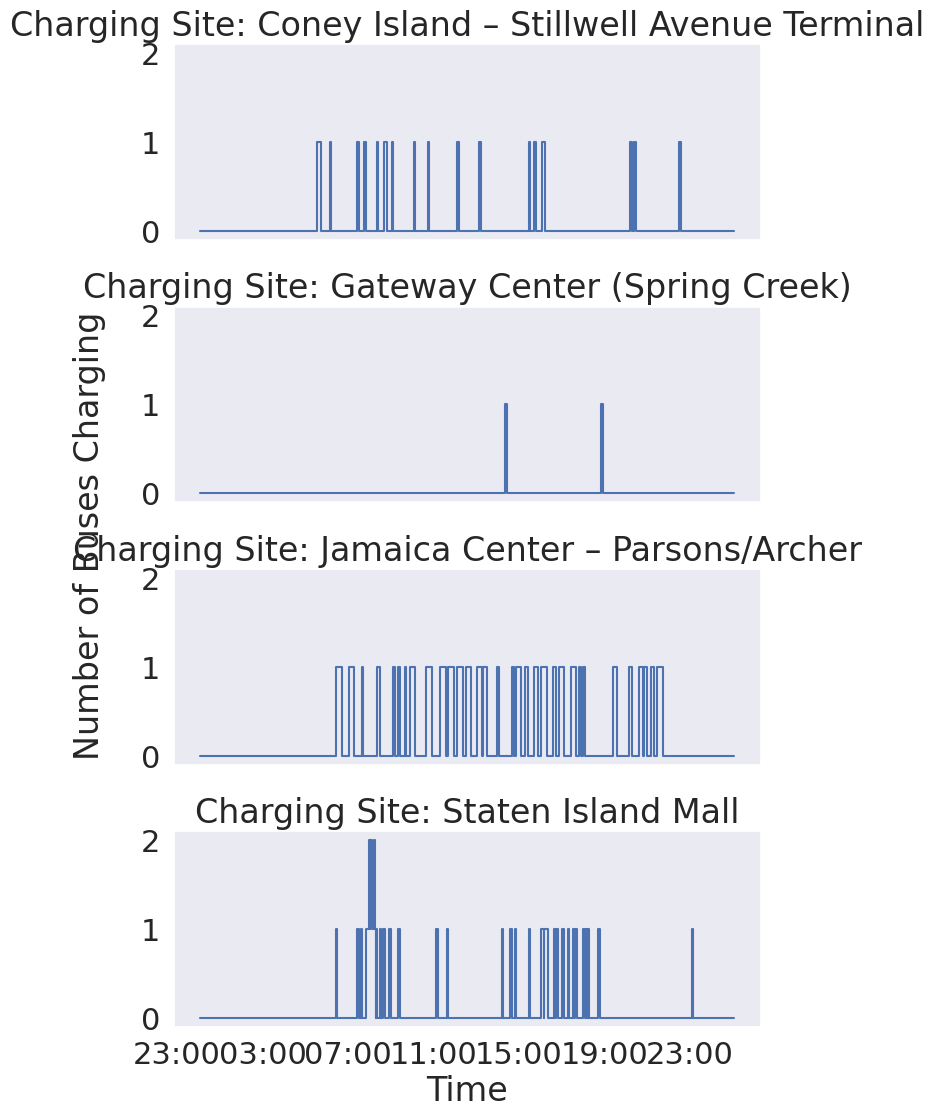

In [43]:
clm.plot_chargers()

In [44]:
fig = plot_deadhead(
    result_df=clm.to_df(), loc_df=loc_df, coords_df=beb_trips
)
fig.show()

INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
